In [2]:
import numpy as np
from scipy.io.wavfile import read
import re
import os
import MFCC
import gmmhmm
from sklearn.model_selection import train_test_split
import pickle

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Problem 1

Write a function which accepts a GMMHMM in the format above as well as an integer n_sim, and which simulates the GMMHMM process, generating n_sim different observations. Do so by implementing the following function declaration. 

In [4]:
def sample_gmmhmm(gmmhmm, n_sim, K=3):
    """
    Simulate sampling from a GMMHMM.

    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, K)
        The generated observations (column vectors of length K)
    """
    # unpack parameters
    A, weights, means, covars, pi = gmmhmm
    
    # Initialize states
    states = []
    obs = []
    
    # Get first state
    states.append(np.argmax(np.random.multinomial(1,pi)))
    
    for _ in range(n_sim):
        # Choose component
        c = np.argmax(np.random.multinomial(1,weights[states[-1],:]))
        # Calculate observation for current step
        obs.append(np.random.multivariate_normal(means[states[-1],c,:], covars[1,c,:,:]))
        # Calculate states for next step
        states.append(np.argmax(np.random.multinomial(1,A[states[-1]])))
        
    return np.array(states[:-1]), np.array(obs)
    

In [5]:
# Establish given data
A = np.array([[.65, .35], [.15, .85]])
pi = np.array([.8, .2])
weights = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
means = np.array([means1, means2])
covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
covars = np.array([covars1, covars2])
g = [A, weights, means, covars, pi]

# get random sample from gmmhmm
states, obs = sample_gmmhmm(g, 10)

print("States and Observations")
states, obs


States and Observations


(array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1], dtype=int64),
 array([[-12.89707725,  -1.68541758,  16.68695231],
        [ 16.1597616 , -33.36007904,   1.65019047],
        [-12.92860617,  -2.40485818,  12.14862573],
        [ 16.86524419, -30.04241479,  -1.71599056],
        [-12.15093569,  -2.60143043,  12.6003268 ],
        [ -0.04025931,  18.25582295,  -5.97625522],
        [ -3.79889113,  19.61419489,  -3.07574167],
        [ 13.45877662, -33.53965777,   0.96651743],
        [ -3.44461982,   1.37357352,  19.79955567],
        [-11.98563212,  -3.73562372,  16.271374  ]]))

## Problem 2 

Obtain 30 (or more) recordings for each of the words/phrases mathematics, biology,
political science, psychology, and statistics. These audio samples should be 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. Load the recordings into Python using scipy.io.wavfile.read.

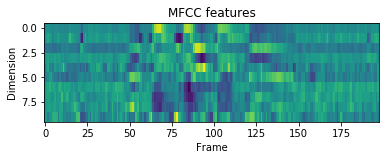

In [6]:
subjects = ["Biology","Mathematics","PoliticalScience", "Psychology","Statistics"]

# Load the data by each subject
data = [[MFCC.extract(read("Samples/{} ({}).wav".format(s,i))[1]) for i in range(1,31)]for s in subjects]

In [8]:
len(data), len(data[0]) # (5, 30)

(5, 30)

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.

Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [9]:
def initialize(n):
    """
    takes in number of states and creates random 
    initial state distribution and transition matrix
    
    inputs:
        n: number of states
        
    outputs:
        startprob: initial state distribution
        transmat: transition matrix
    """
    # create initial state distribution
    startprob = np.random.rand(n)
    startprob /= np.sum(startprob)
    
    # create transition matrix
    transmat = np.random.rand(n,n)
    transmat = (transmat.T/np.sum(transmat, axis=1)).T
    
    # return results
    return startprob, transmat

In [24]:
# Create the models
models = []
for i,s in enumerate(subjects):
    print(s)
    # Track the best_probability
    best_prob = -np.inf

    for j in range(10):
        print('iteration',j)
        # New random initialization each time
        pi,A = initialize(5)
        model = gmmhmm.GMMHMM(n_components=5, n_mix=3, transmat=A, startprob=pi, cvtype='diag')
        model.covars_prior = 0.01
        model.fit(data[i][:20], init_params='mc',var=.1)
        
        # Check log probablity against best model
        if model.logprob > best_prob:
            
            # Track best model
            bestmodel = model
            best_prob = model.logprob
    
    models.append(bestmodel)

# Pickle the best models
for i,s in enumerate(subjects):
    pickle.dump( models[i],open(s+".p","wb") )
    


Biology
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Mathematics
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
PoliticalScience
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Psychology
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
Statistics
iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


In [13]:
models = [pickle.load(open(s+'.p','rb')) for s in subjects]

## Problem 4

Classify the 10 test samples for each word. How does your system perform?
Which words are the hardest to correctly classify? Make a dictionary containing the accuracy
of the classification of your five testing sets. Specifically, the words/phrases will be the keys,
and the values will be the percent accuracy.

In [31]:
acc = {}
for i,s in enumerate(subjects):
    print("Actual:",s)
    highest_probs = np.array([subjects[np.argmax([m.eval(d)[0] for m in models])] for d in data[i][20:]])
    acc[s] = sum(highest_probs == s)/len(highest_probs)
    print("Guesses:", highest_probs)
    print("Accuracy:", acc[s])
    print()
        

Actual: Biology
Guesses: ['Biology' 'Biology' 'Biology' 'Biology' 'Biology' 'Biology' 'Psychology'
 'Biology' 'Biology' 'Mathematics']
Accuracy: 0.8

Actual: Mathematics
Guesses: ['Mathematics' 'Mathematics' 'Mathematics' 'Mathematics' 'Mathematics'
 'Mathematics' 'Mathematics' 'Mathematics' 'Mathematics' 'Mathematics']
Accuracy: 1.0

Actual: PoliticalScience
Guesses: ['PoliticalScience' 'PoliticalScience' 'PoliticalScience'
 'PoliticalScience' 'Psychology' 'PoliticalScience' 'PoliticalScience'
 'PoliticalScience' 'PoliticalScience' 'PoliticalScience']
Accuracy: 0.9

Actual: Psychology
Guesses: ['Psychology' 'Psychology' 'Psychology' 'Psychology' 'Psychology'
 'Psychology' 'Psychology' 'Psychology' 'Psychology' 'Psychology']
Accuracy: 1.0

Actual: Statistics
Guesses: ['Statistics' 'Statistics' 'Statistics' 'Statistics' 'Statistics'
 'Statistics' 'Statistics' 'Statistics' 'Statistics' 'Statistics']
Accuracy: 1.0



These are strong positive results. Biology seems to have been misclassified once as psychology and once as mathematics. Psychology is understandable, I suppose, since they share so much of the same sound structure, but I don't have a good reasoning why Mathematics would have shown up. Political Science was also once mistaken as Psychology once. Again, it seems like an unintuitive mixup, but the true positive rate is still quite significant in these results!